In [ ]:
# Imports
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection
from tempfile import TemporaryDirectory
import seaborn as sns
import time
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
import numpy as np
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(1991)
torch.manual_seed(1991)
torch.cuda.manual_seed(1991)

import random
random.seed(1991)

import numpy as np
np.random.seed(1991)

Running on device: CUDA


In [ ]:
# CIFAR 10 dataset
torch.manual_seed(1991)
# Transformations
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

# Train data
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=normalize
)
# Train loader
train_loader = DataLoader(train_set, batch_size=256, shuffle=True, num_workers=2)

# Test data
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=normalize
)
# Test loader
test_loader = DataLoader(test_set, batch_size=256, shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:13<00:00, 12373055.35it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


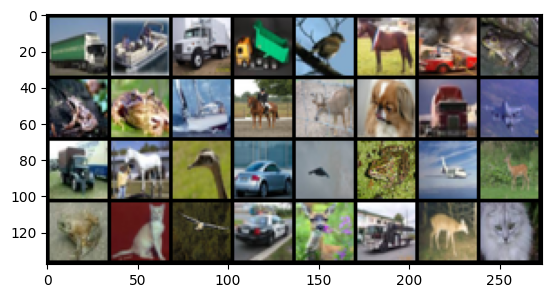

In [ ]:
# Display train images

# Create helper loader
# Train loader
torch.manual_seed(1991)
train_images_display_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)

batch_generator = enumerate(train_images_display_loader)
i, batch = next(batch_generator, 0)

grid_img = torchvision.utils.make_grid(batch[0], nrow=8)
plt.imshow(grid_img.permute(1, 2, 0))

In [ ]:
# Add helping dicts
dataloaders = {
    "train": train_loader,
    "val": test_loader
}

dataset_sizes = {"train": len(train_set), "val": len(test_set)}


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    torch.manual_seed(1991)
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1000

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(DEVICE)
                    labels = labels.to(DEVICE)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train' and scheduler:
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val loss: {best_loss:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:

# Train ResNet18
torch.manual_seed(1991)
model_train = resnet18(weights=None, num_classes=10) # Load resnet18 from pytorch
model_train = model_train.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_train.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.001)

In [ ]:
# Train model Resnet18 21 epochs
model_train = train_model(model_train, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=21)

Epoch 0/20
----------
train Loss: 1.3783 Acc: 0.5059
val Loss: 1.3403 Acc: 0.5194

Epoch 1/20
----------
train Loss: 0.9963 Acc: 0.6468
val Loss: 1.0664 Acc: 0.6220

Epoch 2/20
----------
train Loss: 0.8135 Acc: 0.7113
val Loss: 1.1083 Acc: 0.6372

Epoch 3/20
----------
train Loss: 0.6786 Acc: 0.7597
val Loss: 1.0516 Acc: 0.6589

Epoch 4/20
----------
train Loss: 0.5857 Acc: 0.7924
val Loss: 0.9963 Acc: 0.6741

Epoch 5/20
----------
train Loss: 0.4822 Acc: 0.8291
val Loss: 0.9201 Acc: 0.7108

Epoch 6/20
----------
train Loss: 0.4032 Acc: 0.8581
val Loss: 1.2438 Acc: 0.6445

Epoch 7/20
----------
train Loss: 0.2717 Acc: 0.9087
val Loss: 0.8113 Acc: 0.7401

Epoch 8/20
----------
train Loss: 0.2550 Acc: 0.9174
val Loss: 0.7981 Acc: 0.7452

Epoch 9/20
----------
train Loss: 0.2423 Acc: 0.9218
val Loss: 0.7893 Acc: 0.7472

Epoch 10/20
----------
train Loss: 0.2356 Acc: 0.9246
val Loss: 0.7807 Acc: 0.7493

Epoch 11/20
----------
train Loss: 0.2277 Acc: 0.9279
val Loss: 0.7744 Acc: 0.7516

Ep

In [ ]:
torch.save(model_train.state_dict(), "cifar10_resnet18_baseline.pt")

In [ ]:
# Check accuracy

def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for i, (inputs, targets) in enumerate(loader, 0):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total


print(f"Train set accuracy: {100.0 * accuracy(model_train, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model_train, test_loader):0.1f}%")


Train set accuracy: 93.8%
Test set accuracy: 75.5%


In [ ]:
model_train

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [147]:
model_train.layer4[1].register_forward_hook(get_activation('last_conv_layer'))

In [ ]:
model_train = model_train.to(DEVICE)

In [173]:
df_dict = {
    "label": [],
    "last_conv_layer": [],
    "train": [],
    "loss": []
}

In [175]:
total_num = 0
criterion = nn.CrossEntropyLoss(reduction="none")
for i, batch in enumerate(train_loader, 0):
  images, labels = batch
  images = images.to(DEVICE)
  for image, label in zip(images, labels):
    logits = model_train(image.unsqueeze(0))
    total_num += 1
    losses = criterion(logits, label.unsqueeze(0).to(DEVICE)).numpy(force=True)

    df_dict["loss"].append(losses[0])
    df_dict["label"].append(label)
    df_dict["last_conv_layer"].append(torch.flatten(activation['last_conv_layer']))
    df_dict["train"].append("Тренувальний набір")
    if total_num >= 10000:
      break
  if total_num >= 10000:
    break

In [176]:
max(df_dict["loss"])

5.752797

In [177]:
len(df_dict["last_conv_layer"])

10000

In [178]:
total_num = 0
for i, batch in enumerate(test_loader, 0):
  images, labels = batch
  images = images.to(DEVICE)
  for image, label in zip(images, labels):
    logits = model_train(image.unsqueeze(0))
    total_num += 1
    losses = criterion(logits, label.unsqueeze(0).to(DEVICE)).numpy(force=True)

    df_dict["loss"].append(losses[0])
    df_dict["label"].append(label)
    df_dict["last_conv_layer"].append(torch.flatten(activation['last_conv_layer']))
    df_dict["train"].append("Тестовий набір")

In [179]:
max(df_dict["loss"])

12.322091

In [125]:
len(df_dict["last_conv_layer"])

20000

In [126]:
len(df_dict["loss"])

20000

In [180]:
embeddings = []
for i in range(len(df_dict["last_conv_layer"])):
  embeddings.append(df_dict["last_conv_layer"][i].cpu().numpy())

In [181]:
embeddings_array = np.array(embeddings)
embeddings_array.shape

(20000, 512)

In [182]:
import umap

reducer = umap.UMAP(n_components=3)

In [183]:
embedding = reducer.fit_transform(embeddings_array)

In [184]:
# mapper = {"Тренувальний набір":0, "Тестовий набір":1}

In [185]:
# plt.scatter(
#     embedding[:, 0],
#     embedding[:, 1],
#     c=[sns.color_palette()[mapper[x]] for x in df_dict["train"]])

# plt.gca().set_aspect('equal', 'datalim')
# plt.title('UMAP projection of the Penguin dataset', fontsize=24)

In [186]:
embedding.shape

(20000, 3)

In [187]:
import pandas as pd
embedded_dict = {
    "x": embedding[:, 0],
    "y": embedding[:, 1],
    "z": embedding[:, 2],
    "train": df_dict["train"]
}
df = pd.DataFrame.from_dict(embedded_dict)

In [188]:
import plotly.express as px
fig = px.scatter_3d(df, x='x', y='y', z='z', color='train')

fig.show()

In [189]:
df = pd.DataFrame.from_dict({
    "train": df_dict["train"],
    "loss": df_dict["loss"]
})

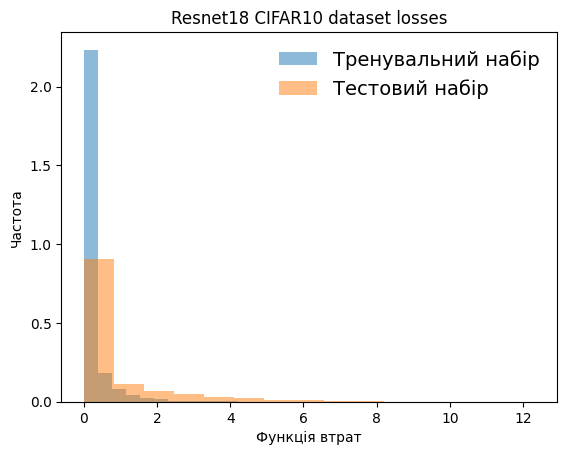

In [192]:
plt.title(f"Resnet18 CIFAR10 dataset losses")
plt.hist(df.loc[df["train"] == "Тренувальний набір"]["loss"], density=True, alpha=0.5, bins=15, label="Тренувальний набір")
plt.hist(df.loc[df["train"] == "Тестовий набір"]["loss"], density=True, alpha=0.5, bins=15, label="Тестовий набір")

plt.ylabel("Частота")
plt.xlabel("Функція втрат")
plt.legend(frameon=False, fontsize=14)
plt.show()

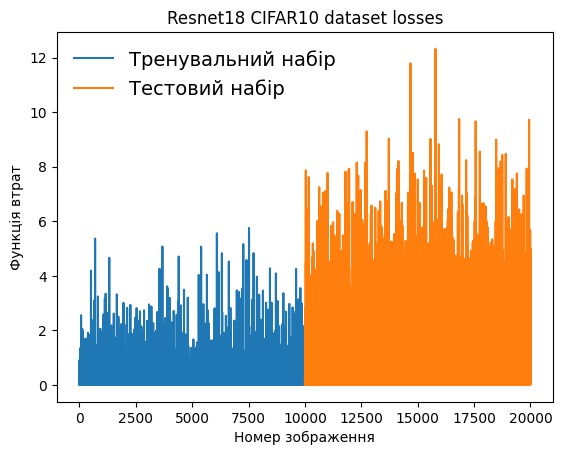

In [195]:
plt.title(f"Resnet18 CIFAR10 dataset losses")
plt.plot(df.loc[df["train"] == "Тренувальний набір"]["loss"], label="Тренувальний набір")
plt.plot(df.loc[df["train"] == "Тестовий набір"]["loss"], label="Тестовий набір")

plt.ylabel("Функція втрат")
plt.xlabel("Номер зображення")
plt.legend(frameon=False, fontsize=14)
plt.show()